In [16]:
# Import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [17]:
# Import and clean data set

df = pd.read_csv('datafile_fullynormalized.txt', sep='\t', header = 0, index_col = 2)

df.index.name = None
df.columns.name = None

# Drop columns by name
df.drop(['Protein', 'Molecule', 'UniProt'], axis=1, inplace=True)

df = df.dropna()

# z-score normalization by row and column
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Copy header as a new row
df.loc['Participant'] = [p[0] for p in df.columns]

# Replace C with "Control"
# Replace P with "Patient"
df.loc['Participant'] = df.loc['Participant'].replace('C', 'Control')
df.loc['Participant'] = df.loc['Participant'].replace('P', 'Patient')

df

,C1,C2,C3,C4,C5,C8,C9,C11,C14,C15,...,P20,P21,P24,P25,P27,P28,P29,P30,P31,P32
CRYBB2,-0.155923,-0.077434,0.076327,-0.092246,-0.099634,-0.213565,-0.156205,-0.006109,-0.217714,-0.295394,...,-0.196247,-0.136961,-0.023329,-0.017172,-0.190572,-0.223638,-0.104625,-0.126161,-0.301357,-0.020061
RAF1,-0.819954,-0.422288,-0.250029,-0.38658,-1.34018,-0.241,-1.238713,-0.965101,-0.372082,0.823319,...,0.603337,0.161373,1.744564,-0.441018,-1.242562,-0.608152,-1.118299,-0.012964,-0.250558,-1.207141
ZNF41,-0.336758,-0.195615,0.368471,-0.358404,0.338861,-0.169301,-0.352554,-0.228103,-0.39214,-0.454878,...,-0.385184,-0.319213,-0.468833,-0.199566,-0.287565,-0.477234,-0.008134,-0.371775,-0.400393,-0.245471
ELK1,-0.114831,-0.161633,-0.343671,-0.094013,-0.179084,-0.403375,-0.300092,-0.391572,-0.329278,-0.352498,...,5.196012,2.372336,0.942285,-0.248658,-0.384573,-0.352218,-0.259752,-0.237139,-0.504867,-0.391734
GUCA1A,-0.053862,-0.381112,-0.351434,0.095208,-0.280967,-0.691102,-0.435207,-0.313981,0.129512,-0.324797,...,0.326561,0.190245,0.728241,-0.531091,0.850408,-0.42613,-0.631577,0.07282,-0.478784,0.189805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATP4B,0.530114,-0.036778,0.517542,0.161288,-0.694473,0.572314,-0.802427,-0.341083,0.284821,-0.081865,...,1.088201,0.019719,-0.581529,-0.755365,-0.66283,-1.020365,0.436483,-0.79997,-1.027387,0.065374
DUT,-0.397775,2.337923,-0.28617,-0.249759,-0.315621,-0.47641,-0.41519,-0.097322,0.019626,-0.157363,...,-0.27538,-0.388659,-0.205653,-0.252135,-0.488705,-0.03987,-0.463779,-0.222421,0.447764,-0.414359
UBXN4,-1.172328,-1.157029,-1.129598,-0.619812,-0.79788,-0.849359,-0.517624,-0.176418,0.569601,0.703957,...,0.029537,-0.503001,0.064878,-0.331447,-0.572269,1.027034,-0.908458,0.366424,1.009578,-0.312934
IRF6,-1.350823,-1.192489,0.10633,-0.9851,-0.906649,-0.04398,-0.372408,-0.732264,0.32177,2.001172,...,0.020584,1.362599,0.32682,-0.218149,0.500626,-0.612657,-0.42478,0.354523,1.462951,-1.548894


In [18]:
# drop the row named "participant"
df = df.drop(np.NaN)

In [19]:
# drop dupes
df = df.drop_duplicates()

In [20]:
# amongst all Participants = Patient, find the top 20 with the highest mean value
df_patient = df.loc[:, df.loc['Participant'] == 'Patient']
df_patient = df_patient.drop('Participant')
df_patient = df_patient.apply(pd.to_numeric)
df_patient = df_patient.mean(axis=1)
df_patient = df_patient.sort_values(ascending=False)
df_patient = df_patient.head(20)

In [21]:
df_patient

AIF1L       0.712078
TNFRSF1A    0.655353
EFNA4       0.647223
PPIC        0.644943
ROR1        0.639099
CRABP2      0.634300
IL18BP      0.629527
HAVCR2      0.606517
TPPP2       0.593549
GDF15       0.591709
UNC5B       0.583836
PXDN        0.583675
NBL1        0.579912
HSPB6       0.570680
IL15RA      0.561887
SELM        0.559028
XXYLT1      0.558581
EFNA5       0.552490
CLMP        0.551234
HSPA1A      0.551130
dtype: float64

In [22]:
# get list of unique genes
genes = df.index[:-1].unique().sort_values(ascending = True)
genes

Index(['10-Sep', '11-Sep', '3-Sep', '6-Sep', 'A1BG', 'A1CF', 'A2M', 'A2ML1',
       'A4GALT', 'A4GNT',
       ...
       'ZPBP2', 'ZPLD1', 'ZWILCH', 'ZWINT', 'ZYX', 'apcA apcB', 'magainins',
       'mdh', 'nodH', 'non-human'],
      dtype='object', length=4738)

In [23]:
participant_labels = df.loc['Participant', :]
df_nolabels = df.drop('Participant', axis=0)

color_map = {'Patient': 'orange', 'Control': 'lightgreen'}
col_colors = participant_labels.map(color_map)

In [24]:
# drop below the 2.5th percentile and above the 97.5th percentile
df_nolabels = df_nolabels.apply(lambda x: np.clip(x, x.quantile(0.025), x.quantile(0.975)), axis=1)

In [25]:
df_nolabels = df_nolabels.apply(pd.to_numeric, errors = "coerce")

In [26]:
df_nolabels_t = df_nolabels.T
corr = df_nolabels_t.corr()

In [27]:
# ignoring corr = 1.00, get the top 20 correlations and plot them
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool))
corr = corr.stack().sort_values(ascending=False)
corr.head(20)

LCAT      UBE2D3      0.998091
DLK1      DLK1        0.996527
LCAT      MFAP3L      0.996312
GCK       ARL6        0.996227
PPBP      PPBP        0.996050
LCAT      ARL6        0.995886
ARL6      MFAP3L      0.995748
FTL       FTH1 FTL    0.995278
UBE2D3    MFAP3L      0.995176
ANXA7     ANXA7       0.995041
NAALADL1  ARL6        0.995039
PPBP      PPBP        0.994962
CHFR      MFAP3L      0.994895
ARL6      UBE2D3      0.994621
PPBP      PPBP        0.994541
CHFR      ARL6        0.994408
GCK       NAALADL1    0.994292
PPA2      ARL6        0.994221
FN1       FN1         0.994085
PPA2      HPGD        0.993700
dtype: float64

In [28]:
gene_of_interest = "LCAT"
correlations = corr.loc[:, gene_of_interest]
ranked_correlations = correlations.sort_values(ascending = False)

# export the top 100 correlations to a txt file, keeping column 0 only
ranked_correlations.to_csv('top100_correlations.txt', sep='\t', header=False)

# remove the numbers from the text file
with open('top100_correlations.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.split('\t')[0] for line in lines]
    lines = [line + '\n' for line in lines]
    lines = lines[0:100]

with open('top100_correlations.txt', 'w') as f:
    f.writelines(lines)

/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


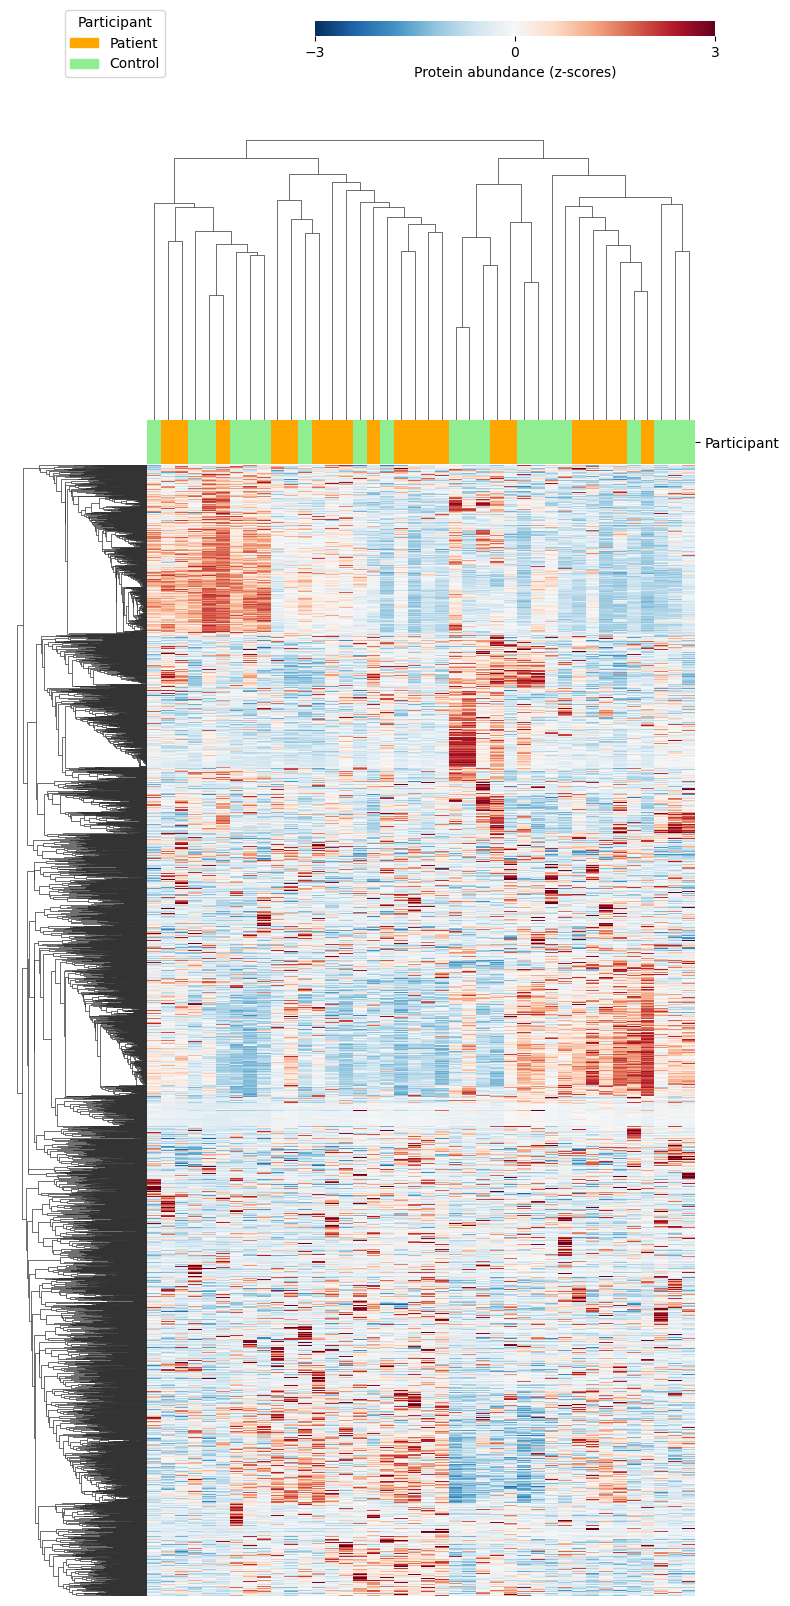

In [29]:
min_color = -3
max_color = 3

hm_average = sns.clustermap(data=df_nolabels,
          method="average",
          metric="correlation",
          xticklabels=[],
          yticklabels=[],
          vmin=min_color,
          vmax=max_color,
          cmap="RdBu_r",
          cbar_pos=(0.4, 1.05, 0.50, 0.01),
          cbar_kws={'orientation': 'horizontal', 'ticks': [min_color, 0, max_color], 'label': 'Protein abundance (z-scores)'},
          col_colors=col_colors,
          figsize=(8, 15))

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, loc='center', bbox_to_anchor=(-0.50, -0.50), title="Participant")

/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


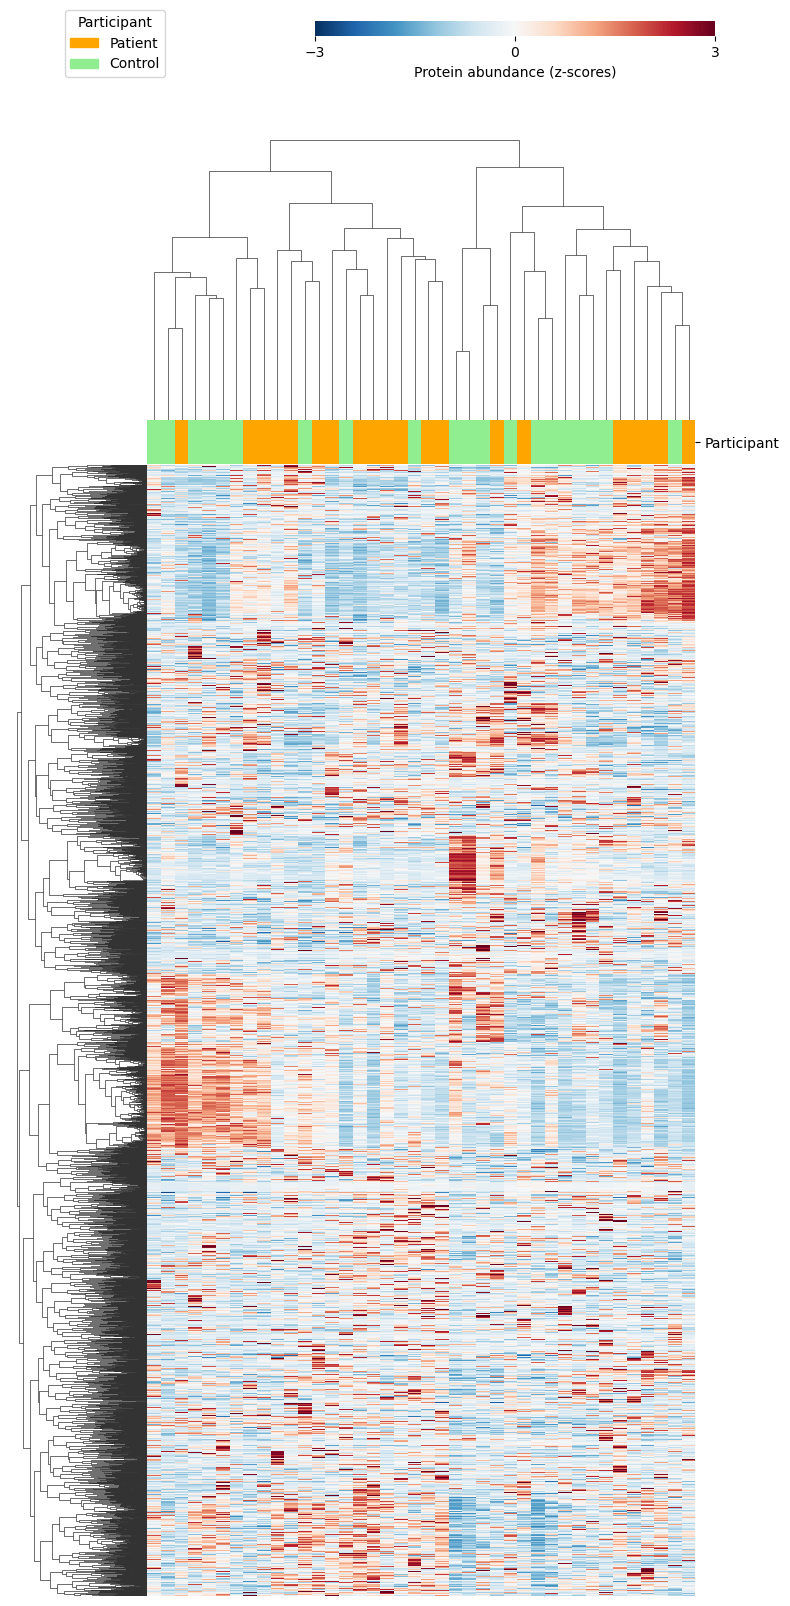

In [30]:
hm_complete = sns.clustermap(data=df_nolabels,
          method="complete",
          metric="correlation",
          xticklabels=[],
          yticklabels=[],
          vmin=min_color,
          vmax=max_color,
          cmap="RdBu_r",
          cbar_pos=(0.4, 1.05, 0.50, 0.01),
          cbar_kws={'orientation': 'horizontal', 'ticks': [min_color, 0, max_color], 'label': 'Protein abundance (z-scores)'},
          col_colors=col_colors,
          figsize=(8, 15))

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, loc='center', bbox_to_anchor=(-0.50, -0.50), title="Participant")